<a href="https://colab.research.google.com/github/jaehwachung/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# # 4bit VLM 처리를 위한 bitsandbytes 설치
# # LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
# !pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# # 필요 시 세션 재시작

In [2]:
# # 한글 처리를 위한 matplotlib 설정 (1)

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache –fv
# !rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [3]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [4]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성(@) 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [5]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [6]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [7]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
# # device_map="auto"를 설정했음에도 GPU 메모리가 너무 부족하다면
torch.cuda.empty_cache()

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
# model = AutoModel.from_pretrained(
model = AutoModelForCausalLM.from_pretrained(
                                'openbmb/MiniCPM-V-2_6-int4',
                                trust_remote_code=True,
                                # device_map="auto",              # GPU/CPU 메모리에 맞춰 자동 배분 (핵심)
                                device_map="cuda:1",              # 'auto' 에러 시 특정 GPU 번호를 직접 지정
                                torch_dtype=torch.float16,      # 메모리 점유를 줄이기 위해 fp16 사용
                                low_cpu_mem_usage=True          # CPU 메모리 사용량 최적화
                             )
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/home/ankus/miniconda3/envs/test_vLLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [8]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

/home/ankus/miniconda3/envs/test_vLLM/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


1


In [9]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [10]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and looking towards the camera, seemingly unamused or indifferent to the book beside it. The background appears to be a wooden surface, possibly a table or floor.


## 14-5 의류 이미지 여부 판단

In [11]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'  # #
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It features a person wearing what appears to be a coordinated outfit consisting of a denim jacket and matching pants. The focus on the attire suggests that it may be used for fashion-related purposes, such as showcasing a particular style or brand.
Yes, this image is of clothing. It appears to be a fashion photograph showcasing the individual's outfit, which includes a layered look with a checkered shirt under a loose-fitting gray jacket and patterned pants. The choice of accessories, such as the sandals, complements the overall style presented in the photo.
Yes
Yes, this image can be considered a picture of clothing. It showcases a man's attire which includes a brown jacket, a yellow sweater, light-colored pants with paint splatters, and brown shoes. The focus on the individual's outfit suggests that it may be used for fashion or style purposes, possibly to highlight a particular look or trend.
Yes.
Yes, this image is of clothing. It showcases a jacket 

## 14-6 의류 판단 결과 시각화

In [12]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,True
5,,True
6,,True
7,,True
8,,True
9,,False


## 14-7 의류 이미지 필터링

In [13]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,True
5,,True
6,,True
7,,True
8,,True
10,,True


## 14-8 의류 스타일 분석

In [14]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipykernel_1913798/1482516394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [15]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image reflects a casual, contemporary fashion trend that is often associated with urban streetwear. The dark denim fabric is a classic choice that has seen a resurgence in popularity due to its versatility and timeless appeal. Denim as a material is known for its durability and ability to be styled in various ways, from rugged workwear to polished, fashionable looks.\n\nThe jacket's oversized fit is indicative of a trend towards more relaxed, comfortable clothing that still maintains a sense of structure. This fits within broader fashion movements that prioritize comfort alongside aesthetics, such as the athleisure trend or the influence of high fashion on everyday wear.\n\nThe color palette is monochromatic, which is a popular choice in minimalist fashion. Monochrome outfits are versatile and can convey a sophisticated look while also being easy to accessorize. The simplicity of the color scheme allows other elements like texture and silhouette to take center stage.\n\nIn terms of color trends, dark hues like navy blue have been consistently popular over the years due to their ability to match with almost any other color. They provide a neutral yet striking option that can be dressed up or down depending on the occasion.\n\nOverall, the outfit represents a blend of practicality and style, appealing to those who value both comfort and a polished appearance."
1,,True,"The style of the clothes in the image leans towards a contemporary, relaxed fashion with an emphasis on comfort and a mix-and-match aesthetic. The pastel pink pants are a statement piece, featuring patchwork details that suggest a blend of traditional craftsmanship with modern design sensibilities. This type of garment could be seen as part of a trend that embraces both casual wear and artisanal elements.\n\nThe gray cardigan adds a layer of versatility to the outfit, allowing for adaptability across different settings. Its soft color complements the pastel tones of the pants without overpowering them, maintaining a cohesive look. The checkered shirt underneath introduces a classic pattern that contrasts with the more unconventional patchwork of the trousers.\n\nThe brown sandals have a rustic feel, which might indicate a preference for earthy tones and natural materials, further enhancing the laid-back vibe of the ensemble. Overall, the clothing suggests a fashion-forward approach that values individuality and eclectic styling, rather than adhering strictly to current trends."
2,,True,"The style of the clothes in the image is indicative of a modern, possibly avant-garde fashion approach. The use of bold colors like orange and black suggests a preference for high-contrast aesthetics that are striking and memorable. This could be part of an artistic or conceptual fashion statement rather than mainstream trends.\n\nThe design itself appears to prioritize form and silhouette over traditional clothing structure, which can be seen as a departure from conventional fashion norms. Such designs often challenge viewers' perceptions of what clothing should look like, pushing boundaries and encouraging discussion about fashion's role in self-expression and identity.\n\nThe text ""joue georges"" implies a playful or whimsical element, suggesting that the clothing may incorporate humor or a sense of fun into its design. This aligns with contemporary fashion trends where individuality and personal expression are highly valued.\n\nIn terms of color trends, bright oranges have been popular in various forms of fashion, particularly in streetwear and casual wear, indicating a trend towards vibrant, eye-catching hues. Black remains a staple in fashion due to its versatility and timeless appeal, often used here to create contrast and highlight specific features of the garment.\n\nOverall, the clothing style reflects a fusion of boldness, playfulness, and innovative design, likely appealing to those who seek unique and e

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [16]:
# # # ST [GPU 간 통신위해] TODO 실패
# import os
# os.environ["NCCL_P2P_DISABLE"] = "1"
# os.environ["NCCL_IB_DISABLE"] = "1"
# # # EN [GPU 간 통신위해]

from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
## LLM 모델 로드 및 설정
# model_name = "LGAI-EXAONE/EXAONE-4.0-1.2B-GPTQ-Int8"
model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"
llm = LLM(
    model=model_name,
    tensor_parallel_size=1,  # # 이전에 device_map="cuda:1", 인 경우 TODO (성공)
    # tensor_parallel_size=2,  # # [GPU 간 통신위해(중요)] 사용할 GPU의 개수를 입력 TODO 실패
    dtype="half",
    gpu_memory_utilization=0.6, # # 메모리 사용량 0.6(최대 60%)까지 사용 설정  # # [GPU 간 통신위해] 각 GPU 메모리의 0.X(X0%)를 점유... TODO 실패  
    max_model_len=10000,  # # 10000,  
    trust_remote_code=True,
    # swap_space=4,
)

2025-12-31 09:54:48,870	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-31 09:54:49 __init__.py:207] Automatically detected platform cuda.
INFO 12-31 09:54:50 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 12-31 09:54:56 config.py:549] This model supports multiple tasks: {'score', 'generate', 'embed', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 12-31 09:54:56 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=Observabili

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.03it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.05s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.04s/it]



INFO 12-31 09:55:02 model_runner.py:1115] Loading model weights took 4.5145 GB
INFO 12-31 09:55:03 worker.py:267] Memory profiling takes 1.16 seconds
INFO 12-31 09:55:03 worker.py:267] the current vLLM instance can use total_gpu_memory (10.75GiB) x gpu_memory_utilization (0.60) = 6.45GiB
INFO 12-31 09:55:03 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.05GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 0.90GiB.
INFO 12-31 09:55:03 executor_base.py:111] # cuda blocks: 782, # CPU blocks: 3495
INFO 12-31 09:55:03 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 1.25x
INFO 12-31 09:55:07 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utiliz

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:18<00:00,  1.93it/s]

INFO 12-31 09:55:25 model_runner.py:1562] Graph capturing finished in 18 secs, took 0.21 GiB
INFO 12-31 09:55:25 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 23.02 seconds


## 14-10 색상 정보 추출

In [17]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 12-31 09:55:25 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
WARNING 12-31 09:55:25 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s, est. speed input: 38.66 toks/s, output: 84.14 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks based on the extensive training data I've been provided. Whether you have questions about AI technologies, need help with specific tasks, or require explanations on various topics, feel free to ask! How can I assist you today?
WARNING 12-31 09:55:26 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, est. speed input: 53.96 toks/s, output: 84.11 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:26 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, est. speed input: 55.91 toks/s, output: 83.86 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research to assist with your inquiries. How can I help you today? Feel free to ask about my capabilities, limitations, or any specific tasks you need assistance with.
WARNING 12-31 09:55:27 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, est. speed input: 55.94 toks/s, output: 83.91 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research to assist with your inquiries. How can I help you today? Feel free to ask about my capabilities, limitations, or any specific tasks you need assistance with!
WARNING 12-31 09:55:28 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, est. speed input: 52.07 toks/s, output: 84.22 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks while adhering to ethical guidelines. How can I help you today? Feel free to ask about my capabilities or any specific inquiries you have!
WARNING 12-31 09:55:28 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, est. speed input: 47.43 toks/s, output: 85.09 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks based on the capabilities provided by LG AI Research. How can I help you today? Feel free to ask about any specific inquiries or tasks you need assistance with!
WARNING 12-31 09:55:29 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, est. speed input: 48.95 toks/s, output: 84.95 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks based on the capabilities provided by LG AI Research. How can I help you today? Feel free to ask about specific functionalities or any questions you might have!
WARNING 12-31 09:55:30 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s, est. speed input: 51.44 toks/s, output: 84.73 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with inquiries across various topics, providing accurate and helpful responses based on my training data up to April 2024. How can I assist you today?
WARNING 12-31 09:55:30 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, est. speed input: 51.13 toks/s, output: 84.21 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with inquiries across various topics, providing accurate and helpful responses based on my training data up to April 2024. How can I assist you today?
WARNING 12-31 09:55:31 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, est. speed input: 56.07 toks/s, output: 84.10 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific topics or functionalities within my capabilities.
WARNING 12-31 09:55:32 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 54.07 toks/s, output: 84.28 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!



/tmp/ipykernel_1913798/4139406670.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [18]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

WARNING 12-31 09:55:32 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 54.13 toks/s, output: 84.37 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:33 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 54.10 toks/s, output: 84.33 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:33 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 54.09 toks/s, output: 84.31 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:34 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, est. speed input: 56.10 toks/s, output: 84.15 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research to assist with your inquiries. How can I help you today? Feel free to ask about my capabilities, limitations, or any specific tasks you need assistance with!
WARNING 12-31 09:55:35 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s, est. speed input: 52.87 toks/s, output: 83.97 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks as requested. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:35 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it, est. speed input: 29.39 toks/s, output: 87.31 toks/s]

Hello! As EXAONE 3.5 from LG AI Research, my primary function is to assist with information and tasks based on the capabilities provided by my training data up to April 2024. I excel at generating human-like text responses, answering questions, and performing language-based tasks. For the most accurate and up-to-date information beyond my training cutoff, please refer to the latest resources or directly contact relevant experts or platforms. How can I assist you today?
WARNING 12-31 09:55:37 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, est. speed input: 55.20 toks/s, output: 84.42 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific inquiries or tasks you need assistance with!
WARNING 12-31 09:55:37 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, est. speed input: 50.59 toks/s, output: 84.81 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with inquiries across various topics, providing accurate and helpful responses based on my training data up to April 2024. How can I assist you today?
WARNING 12-31 09:55:38 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, est. speed input: 55.18 toks/s, output: 84.40 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!
WARNING 12-31 09:55:38 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, est. speed input: 54.18 toks/s, output: 84.45 toks/s]

Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific inquiries or tasks you need assistance with!
WARNING 12-31 09:55:39 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.



Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, est. speed input: 55.11 toks/s, output: 84.29 toks/s]

Hello! I am EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!



/tmp/ipykernel_1913798/1057586153.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_color)


In [19]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image reflects a casual, contemporary fashion trend that is often associated with urban streetwear. The dark denim fabric is a classic choice that has seen a resurgence in popularity due to its versatility and timeless appeal. Denim as a material is known for its durability and ability to be styled in various ways, from rugged workwear to polished, fashionable looks.\n\nThe jacket's oversized fit is indicative of a trend towards more relaxed, comfortable clothing that still maintains a sense of structure. This fits within broader fashion movements that prioritize comfort alongside aesthetics, such as the athleisure trend or the influence of high fashion on everyday wear.\n\nThe color palette is monochromatic, which is a popular choice in minimalist fashion. Monochrome outfits are versatile and can convey a sophisticated look while also being easy to accessorize. The simplicity of the color scheme allows other elements like texture and silhouette to take center stage.\n\nIn terms of color trends, dark hues like navy blue have been consistently popular over the years due to their ability to match with almost any other color. They provide a neutral yet striking option that can be dressed up or down depending on the occasion.\n\nOverall, the outfit represents a blend of practicality and style, appealing to those who value both comfort and a polished appearance.","Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks based on the extensive training data I've been provided. Whether you have questions about AI technologies, need help with specific tasks, or require explanations on various topics, feel free to ask! How can I assist you today?","Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!"
1,,True,"The style of the clothes in the image leans towards a contemporary, relaxed fashion with an emphasis on comfort and a mix-and-match aesthetic. The pastel pink pants are a statement piece, featuring patchwork details that suggest a blend of traditional craftsmanship with modern design sensibilities. This type of garment could be seen as part of a trend that embraces both casual wear and artisanal elements.\n\nThe gray cardigan adds a layer of versatility to the outfit, allowing for adaptability across different settings. Its soft color complements the pastel tones of the pants without overpowering them, maintaining a cohesive look. The checkered shirt underneath introduces a classic pattern that contrasts with the more unconventional patchwork of the trousers.\n\nThe brown sandals have a rustic feel, which might indicate a preference for earthy tones and natural materials, further enhancing the laid-back vibe of the ensemble. Overall, the clothing suggests a fashion-forward approach that values individuality and eclectic styling, rather than adhering strictly to current trends.","Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!","Hello! I'm EXAONE 3.5, developed by LG AI Research. My purpose is to assist with information and tasks efficiently. How can I help you today? Feel free to ask about any specific queries or tasks you need assistance with!"
2,,True,"The style of the clothes in the image is indicative of a modern, possibly avant-garde fashion approach. The use of bold colors like orange and black suggests a preference for high-contrast aesthetics that are striking and memorable. This could be part of an artistic or conceptual fashion statement rather than mainstream trends.\n\nThe design itself appears to prioritize form and silhouette over traditional clothing struct

## 14-12 텍스트 데이터 정제

In [20]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipykernel_1913798/2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipykernel_1913798/2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

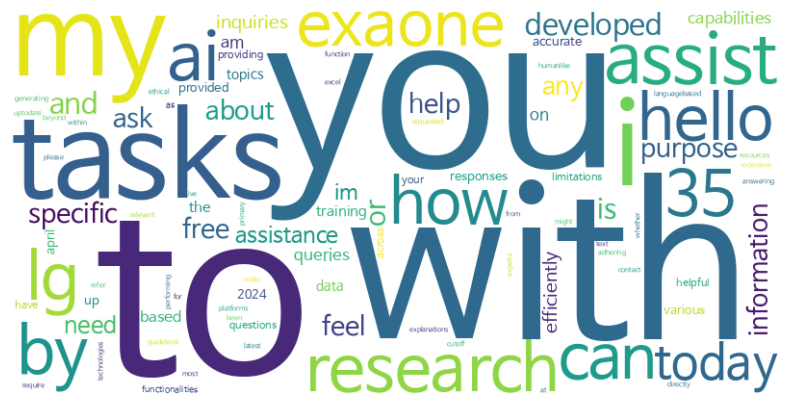

In [24]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    # plt.imshow(wordcloud, interpolation='bilinear')  # # wordcloud 내부의 to_array() 메서드가 넘파이의 asarray()를 호출할 때, 예전에는 묵인되었던 copy 인자가 최신 넘파이에서는 문제
    wordcloud_array = np.array(wordcloud.to_image())
    plt.imshow(wordcloud_array, interpolation='bilinear')
    # plt.imshow(np.array(wordcloud), interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [25]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f""})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": ""})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with empty / unparsable content.
WARNING 12-31 10:01:43 chat_utils.py:825] Skipping multimodal part (type: 'text')with em

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, est. speed input: 122.48 toks/s, output: 78.39 toks/s]


In [26]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

It seems like there might have been a misunderstanding or an interruption in your message. Could you please provide more details or clarify what you would like assistance with? Whether it's related to AI technology, specific tasks, or any other inquiries, feel free to elaborate so I can offer the most accurate and helpful guidance!